In [1]:
%pip install transformers 
%pip install datasets 
%pip install scikit-learn
%pip install torch
%pip install datasets
%pip install accelerate

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip in

### **1. Loading the Data**
In this part, we load the dataset from a CSV file and preprocess it. We also convert the difficulty levels into numeric labels for classification.

In [39]:
import pandas as pd
train_data = pd.read_csv("./Data/train_data.csv")
test_data = pd.read_csv("./Data/test_data.csv")

print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")

Train size: 2817
Test size: 705


### **2. Call to the API**
Evaluate the model on the test set to check its performance using metrics like accuracy, precision, recall, and F1-score.

In [ ]:
import openai
import pandas as pd
import time
from tqdm import tqdm

# Set your OpenAI API key
client = openai.OpenAI(api_key="")

# Define the model to use
MODEL_NAME = "gpt-4o"

# Define prompt template
PROMPT_TEMPLATE = """ 
You are a language assessor using the Common European Framework of Reference for Languages (CEFR).
Your task is to assign a language proficiency score to this text, using the CEFR levels from A1 (beginner) to C2 (advanced/native). 
Evaluate the given text and **ONLY** return one of the following levels: A1, A2, B1, B2, C1, or C2.
Do not provide any explanation or additional text. Just return the level.

Text: "{}"
"""

# Function to make API call to OpenAI
def query_openai_gpt(sentence, model=MODEL_NAME):
    """
    Queries OpenAI's GPT model to classify a sentence into CEFR levels.
    
    :param sentence: The German sentence to classify.
    :param model: The GPT model to use (e.g., "gpt-4o-mini").
    :return: The predicted CEFR level (A1 to C2) or None in case of an error.
    """
    prompt = PROMPT_TEMPLATE.format(sentence)

    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a CEFR language proficiency classifier."},
                {"role": "user", "content": prompt},
            ],
            # Set the temperature to 0 to get deterministic results
            temperature=0,
            # Set the max_tokens to 2 to get only the predicted level
            max_tokens=2,
        )
        return response.choices[0].message.content.strip()
    
    except openai.APIError as e:
        print(f"OpenAI API Error: {e}")
        return None
    except openai.APIConnectionError as e:
        print(f"Connection Error: {e}")
        return None
    except openai.RateLimitError as e:
        print(f"Rate Limit Exceeded: {e}")
        return None
    



In [52]:
print(query_openai_gpt("Ich bin ein heisse Dimitri."))  # Example usage

A1


In [30]:
# get sample of test data
sample_test_data = test_data.sample(100)
display(sample_test_data)

,sentence,difficulty,text_id,sentence_length,sentence_tokens,total_tokens_per_call,difficulty_reviewed,readability,difficulty_label
352,Eins ist mit dem Helikopter gekommen.,1,450,6,9.0,115.0,A2,90.77,A2
423,Seit ihrer Gründung im Jahr 1949 hat sich der ...,5,unknown,30,NaN,NaN,C2,39.33,C2
541,Oder sie werden von uns ausgeblendet .,1,290,7,9.0,113.0,A2,73.85,A2
83,Von den über 4. 000 Pflanzenarten und fast 45....,3,669,18,NaN,NaN,B2,99.23,B2
124,Die meisten Neubauten erinnern an kleine Landh...,5,unknown,28,NaN,NaN,C2,44.07,C2
...,...,...,...,...,...,...,...,...,...
285,Ich find' die blauen Lichter immer sehr schön.,1,485,8,12.0,115.0,A2,105.66,A2
409,Und die Deutschen waren schließlich sehr erfol...,4,288,35,59.0,176.0,C1,44.41,C1
463,"Gewiss stieß das Werk auf Widerstand, geprägt ...",5,unknown,24,NaN,NaN,C2,73.51,C2
684,Das Seminar beginnt in zwei Minuten.,0,469,6,NaN,NaN,A1,56.93,A1


In [53]:
import pandas as pd

# Load your test sentences
test_sentences = test_data["sentence"].tolist()  # Ensure this contains actual text
y_true = test_data["difficulty_label"].tolist()  # True difficulty levels

# Models to test
gpt_models = ["gpt-3.5-turbo", "gpt-4o-mini", "gpt-4o"]

# Dictionary to store predictions
gpt_predictions = {}

for model in gpt_models:
    print(f"Testing {model}...")
    y_pred = [query_openai_gpt(sentence, model=model) for sentence in test_sentences]
    gpt_predictions[model] = y_pred
    time.sleep(1)  # Avoid API rate limits

# Convert to DataFrame
df_results = pd.DataFrame({"sentence": test_sentences, "true_label": y_true})
for model in gpt_models:
    df_results[model] = gpt_predictions[model]

display(df_results)

# Save results
df_results.to_csv("gpt_predictions.csv", index=False)
print("Predictions saved!")


Testing gpt-3.5-turbo...
Testing gpt-4o-mini...
Testing gpt-4o...


,sentence,true_label,gpt-3.5-turbo,gpt-4o-mini,gpt-4o
0,Es steht an gefährlichen Kreuzungen oder Einmü...,B2,B2,C1,B2
1,1988 entstand in den USA die „International Da...,C1,C1,C1,C1
2,"Die Denkweise, Häuser als Maschinen, in denen ...",C2,C1,C1,C1
3,Architekten können heute keine Bauwerke mehr s...,C2,C1,C1,C1
4,60 Prozent verwenden das Taschengeld auch für ...,B1,B1,B1,A2
...,...,...,...,...,...
700,Es gibt auch Begriffe aus der gesprochenen Spr...,B2,C1,B2,B2
701,Inzwischen sind die Menschen aber bestens info...,C1,C1,C1,C1
702,Nur rund 14 Prozent ihres Einkommens gaben sie...,B1,C1,B2,B2
703,In meiner ersten Woche habe ich drei Teller fa...,A2,B1,A2,A2


Predictions saved!


In [54]:
# display classification report
from sklearn.metrics import classification_report

for model in gpt_models:
    print(f"Results for {model}:")
    print(classification_report(y_true, gpt_predictions[model]))
    

Results for gpt-3.5-turbo:
              precision    recall  f1-score   support

          A1       1.00      0.15      0.27       117
          A2       0.12      0.02      0.03       117
          B1       0.19      0.32      0.24       118
          B2       0.20      0.14      0.16       118
          C1       0.30      0.97      0.46       118
          C2       0.75      0.03      0.05       117

    accuracy                           0.27       705
   macro avg       0.43      0.27      0.20       705
weighted avg       0.43      0.27      0.20       705

Results for gpt-4o-mini:
              precision    recall  f1-score   support

          A1       0.97      0.97      0.97       117
          A2       0.95      0.93      0.94       117
          B1       0.93      0.94      0.93       118
          B2       0.94      0.88      0.91       118
          C1       0.53      0.98      0.69       118
          C2       0.96      0.21      0.34       117

    accuracy             


Generating Confusion Matrix for gpt-3.5-turbo...


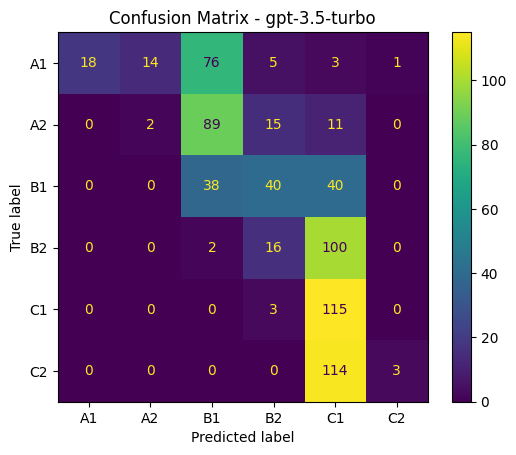


Generating Confusion Matrix for gpt-4o-mini...


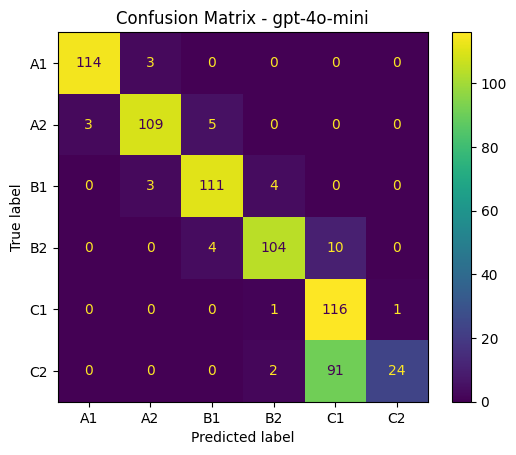


Generating Confusion Matrix for gpt-4o...


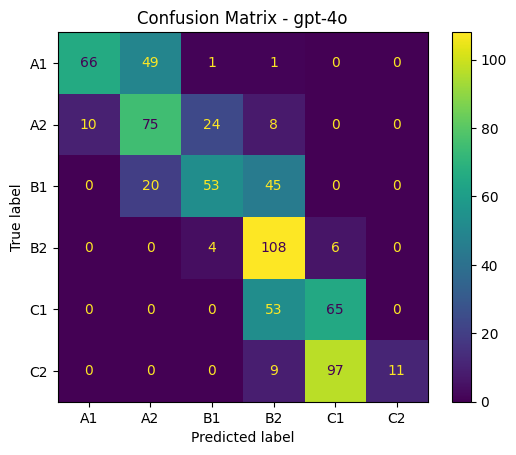

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# CEFR Mapping (A1=0, A2=1, ..., C2=5)
cefr_mapping = {"A1": 0, "A2": 1, "B1": 2, "B2": 3, "C1": 4, "C2": 5}
labels = ["A1", "A2", "B1", "B2", "C1", "C2"]

# Convert true labels to numerical format
y_true_numeric = df_results["true_label"].map(cefr_mapping).tolist()

# Iterate over each model to compute and plot confusion matrices
for model in df_results.columns[2:]:  # Skip "sentence" and "true_label"
    print(f"\nGenerating Confusion Matrix for {model}...")

    # Convert predictions to numeric format
    y_pred_numeric = df_results[model].map(cefr_mapping).tolist()

    # Filter out invalid predictions (None values)
    valid_indices = [i for i in range(len(y_pred_numeric)) if y_pred_numeric[i] is not None]
    y_true_filtered = [y_true_numeric[i] for i in valid_indices]
    y_pred_filtered = [y_pred_numeric[i] for i in valid_indices]

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_filtered, y_pred_filtered, labels=range(6))

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
    disp.plot(cmap="viridis")
    plt.title(f"Confusion Matrix - {model}")
    plt.show()

# Pairewise Mismmatch metric
The pairwise mismatch metric focuses on computing ordering violations in predictions relative to ground truth.
<img src="./Images/Pairewise-Matchinge-Explanation.png" width="800px">

In [8]:
import pandas as pd
df_results = pd.read_csv("gpt_predictions-zero-shot.csv")

display(df_results)

,sentence,true_label,gpt-3.5-turbo,gpt-4o-mini,gpt-4o
0,Es steht an gefährlichen Kreuzungen oder Einmü...,B2,B2,C1,B2
1,1988 entstand in den USA die „International Da...,C1,C1,C1,C1
2,"Die Denkweise, Häuser als Maschinen, in denen ...",C2,C1,C1,C1
3,Architekten können heute keine Bauwerke mehr s...,C2,C1,C1,C1
4,60 Prozent verwenden das Taschengeld auch für ...,B1,B1,B1,A2
...,...,...,...,...,...
700,Es gibt auch Begriffe aus der gesprochenen Spr...,B2,C1,B2,B2
701,Inzwischen sind die Menschen aber bestens info...,C1,C1,C1,C1
702,Nur rund 14 Prozent ihres Einkommens gaben sie...,B1,C1,B2,B2
703,In meiner ersten Woche habe ich drei Teller fa...,A2,B1,A2,A2


In [7]:
from sklearn.preprocessing import LabelEncoder

def pairwise_mismatch(y_pred: pd.Series, y_real: pd.Series) -> float:
    """
    Compute the pairwise mismatch metric as described by Henry Jamet.
    
    :param y_pred: Pandas Series of predicted difficulty levels
    :param y_real: Pandas Series of true difficulty levels
    :return: Mean pairwise mismatch score
    """
    predictions = pd.DataFrame({"pred": y_pred, "real": y_real})

    # Sort alphabetically by real and predicted labels
    predictions = predictions.sort_values(by=["real", "pred"])

    # Convert categorical labels into numeric values while keeping order
    predictions["pred"] = predictions["pred"].astype("category")
    predictions["real"] = predictions["real"].astype("category")

    # Initialize LabelEncoder and encode labels
    label_encoder = LabelEncoder()
    unique_labels = pd.unique(predictions[["pred", "real"]].values.ravel("K"))
    label_encoder.fit(unique_labels)

    predictions["pred"] = label_encoder.transform(predictions["pred"])
    predictions["real"] = label_encoder.transform(predictions["real"])

    # Compute the pairwise mismatch
    mismatch = (
        predictions["pred"].expanding().apply(lambda s: (s.iloc[-1] - s < 0).sum())
        + predictions["pred"][::-1]
        .expanding()
        .apply(lambda s: (s.iloc[-1] - s > 0).sum())[::-1]
    )

    return mismatch.mean()

# Compute pairwise mismatch for each GPT model
for model in df_results.columns[2:]:  

    # Convert true labels and predictions to Pandas Series
    y_true_series = pd.Series(df_results["true_label"])
    y_pred_series = pd.Series(df_results[model])

    # Compute mismatch score
    mismatch_score = pairwise_mismatch(y_pred_series, y_true_series)
    print(f"Pairwise Mismatch Score ({model}): {mismatch_score:.4f}")


Pairwise Mismatch Score (gpt-3.5-turbo): 13.9461
Pairwise Mismatch Score (gpt-4o-mini): 1.1206
Pairwise Mismatch Score (gpt-4o): 8.5504
